<a href="https://colab.research.google.com/github/zachfreitas/ADS_505_Applied_Data_Sci_for_Business-/blob/main/Module_2/Assignment_2/Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2.1
Zachariah Freitas 2022-09-11

## Import required packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install dmba

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 11.6 MB/s 


In [3]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pylab as plt

import dmba
from dmba import regressionSummary
from dmba import adjusted_r2_score, AIC_score, BIC_score
from dmba import backward_elimination, forward_selection, stepwise_selection

from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

%matplotlib inline

no display found. Using non-interactive Agg backend


In [4]:
# Get data
ts_df = pd.read_csv('https://raw.githubusercontent.com/zachfreitas/ADS_505_Applied_Data_Sci_for_Business-/main/Module_2/Assignment_2/Tayko.csv')
print(ts_df.shape)
print(ts_df.columns)
ts_df

(2000, 25)
Index(['sequence_number', 'US', 'source_a', 'source_c', 'source_b', 'source_d',
       'source_e', 'source_m', 'source_o', 'source_h', 'source_r', 'source_s',
       'source_t', 'source_u', 'source_p', 'source_x', 'source_w', 'Freq',
       'last_update_days_ago', '1st_update_days_ago', 'Web order',
       'Gender=male', 'Address_is_res', 'Purchase', 'Spending'],
      dtype='object')


,sequence_number,US,source_a,source_c,source_b,source_d,source_e,source_m,source_o,source_h,...,source_x,source_w,Freq,last_update_days_ago,1st_update_days_ago,Web order,Gender=male,Address_is_res,Purchase,Spending
0,1,1,0,0,1,0,0,0,0,0,...,0,0,2,3662,3662,1,0,1,1,128
1,2,1,0,0,0,0,1,0,0,0,...,0,0,0,2900,2900,1,1,0,0,0
2,3,1,0,0,0,0,0,0,0,0,...,0,0,2,3883,3914,0,0,0,1,127
3,4,1,0,1,0,0,0,0,0,0,...,0,0,1,829,829,0,1,0,0,0
4,5,1,0,1,0,0,0,0,0,0,...,0,0,1,869,869,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1996,1,0,0,0,0,0,0,0,0,...,0,0,1,1701,1701,1,0,0,1,30
1996,1997,1,0,0,0,0,0,0,0,0,...,0,0,1,2633,2633,1,1,0,1,10
1997,1998,1,0,0,0,0,0,0,0,0,...,0,0,0,3394,3394,0,0,0,0,0
1998,1999,1,0,0,0,0,0,0,0,0,...,0,1,1,253,253,0,1,1,0,0


## Question 1

Each catalog costs approximately $2 to mail (including printing, postage, and mailing costs). Estimate the gross profit that the firm could expect from the remaining 180,000 names if it selects them randomly from the pool. (6 Points)

In [82]:
# Calculate Gross Profit on 180k Names
historical_response_rate = 1065/20000 # Purchasers / Test Mailing Customer List - Approx:0.053
model_response_rate = 1000/2000 # Purchasers / (Purchasers + NonPurchasers) - Approx:0.5
probability_of_purchase = historical_response_rate/model_response_rate
list_size = 180000
potential_customers = probability_of_purchase * list_size
avg_cost = 2.0
avg_spend = ts_df.loc[ts_df['Purchase'] == 1]['Spending'].mean()
exp_avg_profit = (avg_spend - avg_cost)
gross_profit = potential_customers * exp_avg_profit

# Print Results
print(f'Historical Response Rate = {historical_response_rate:,.4f}')
print(f'Model Response Rate = {model_response_rate:,.4f}')
print(f'Probability of Purchase = {probability_of_purchase:,.4f}')
print(f'Expected Number of Purchase Customers = {potential_customers:,.0f}')

print(f'Expected Average Spend Per Customer = ${avg_spend:,.2f}')
print(f'Expected Average Cost Per Customer = ${avg_cost:,.2f}')
print(f'Expected Average Profit Per Customer = ${exp_avg_profit:,.2f}')
print(f'Expected Gross Profit = ${gross_profit:,.2f}')

Historical Response Rate = 0.0532
Model Response Rate = 0.5000
Probability of Purchase = 0.1065
Expected Number of Purchase Customers = 19,170
Expected Average Spend Per Customer = $205.25
Expected Average Cost Per Customer = $2.00
Expected Average Profit Per Customer = $203.25
Expected Gross Profit = $3,896,283.33


## Question 2
Develop a model for classifying a customer as a purchaser or nonpurchaser

### Question 2.1
Partition the data randomly into a training set (800 records), validation set (700 records), and test set (500 records). (6 Points)


In [6]:
# Partition Data Set into Test Train.
trainData, testData = train_test_split(ts_df, test_size=0.25, random_state=1)
print('Train + Validation Data:',trainData.shape, 'Test Data:', testData.shape)

# The validation set is used to fine-tune the hyperparameters of the model and is considered a part of the training of the model. 
train_Data, valid_Data = train_test_split(trainData, test_size=(700/trainData.shape[0]), random_state=1)
print('Train Data:',train_Data.shape, 'Validation Data:', valid_Data.shape)

Train + Validation Data: (1500, 25) Test Data: (500, 25)
Train Data: (800, 25) Validation Data: (700, 25)


### Question 2.2
Run logistic regression with L2 penalty, using method LogisticRegressionCV, to
select the best subset of variables, then use this model to classify the data into purchasers and nonpurchasers. Use only the training set for running the model. (Logistic regression is used because it yields an estimated “probability of purchase,” which is required later in the analysis.) (6 Points)

In [7]:
# Data Review
ts_df.describe().T

,count,mean,std,min,25%,50%,75%,max
sequence_number,2000.0,1000.5000,577.494589,1.0,500.75,1000.5,1500.25,2000.0
US,2000.0,0.8245,0.380489,0.0,1.00,1.0,1.00,1.0
source_a,2000.0,0.1265,0.332495,0.0,0.00,0.0,0.00,1.0
source_c,2000.0,0.0560,0.229979,0.0,0.00,0.0,0.00,1.0
source_b,2000.0,0.0600,0.237546,0.0,0.00,0.0,0.00,1.0
source_d,2000.0,0.0415,0.199493,0.0,0.00,0.0,0.00,1.0
source_e,2000.0,0.1510,0.358138,0.0,0.00,0.0,0.00,1.0
source_m,2000.0,0.0165,0.127420,0.0,0.00,0.0,0.00,1.0
source_o,2000.0,0.0335,0.179983,0.0,0.00,0.0,0.00,1.0
source_h,2000.0,0.0525,0.223089,0.0,0.00,0.0,0.00,1.0


In [8]:
pd.DataFrame(ts_df.loc[ts_df['Purchase'] < 1]['Purchase']).sort_values(['Purchase'], ascending=False)

,Purchase
1,0
1378,0
1354,0
1355,0
1356,0
...,...
746,0
747,0
748,0
750,0


In [9]:
ts_df.columns

Index(['sequence_number', 'US', 'source_a', 'source_c', 'source_b', 'source_d',
       'source_e', 'source_m', 'source_o', 'source_h', 'source_r', 'source_s',
       'source_t', 'source_u', 'source_p', 'source_x', 'source_w', 'Freq',
       'last_update_days_ago', '1st_update_days_ago', 'Web order',
       'Gender=male', 'Address_is_res', 'Purchase', 'Spending'],
      dtype='object')

In [10]:
from sklearn import preprocessing
# Prep data for Logistic Regression model
#scaler = preprocessing.StandardScaler()

scaler = preprocessing.MinMaxScaler()
# Fit the scaler in trianing dataset.
scaler.fit(train_Data[['1st_update_days_ago', 'last_update_days_ago', 'Freq']])  # Note the use of an array of column names

# Transform the full dataset
ts_df_Norm = pd.concat([ts_df[['sequence_number', 'US', 'source_a', 'source_c', 'source_b', 'source_d',
                              'source_e', 'source_m', 'source_o', 'source_h', 'source_r', 'source_s',
                              'source_t', 'source_u', 'source_p', 'source_x', 'source_w', 'Web order',
                              'Gender=male', 'Address_is_res', 'Purchase', 'Spending']],
                        pd.DataFrame(scaler.transform(ts_df[['1st_update_days_ago', 'last_update_days_ago', 'Freq']]), 
                                    columns=['1st_update_days_ago', 'last_update_days_ago', 'Freq'])], axis=1)

# Break-out the test and train datasets based on indexes
trainNorm = ts_df_Norm.iloc[train_Data.index]
display(trainNorm)

validNorm = ts_df_Norm.iloc[valid_Data.index]
display(validNorm)

testNorm = ts_df_Norm.iloc[testData.index]
display(testNorm)


,sequence_number,US,source_a,source_c,source_b,source_d,source_e,source_m,source_o,source_h,...,source_x,source_w,Web order,Gender=male,Address_is_res,Purchase,Spending,1st_update_days_ago,last_update_days_ago,Freq
746,747,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.469027,0.469027,0.076923
617,618,1,1,0,0,0,0,0,0,0,...,0,0,1,0,0,1,1195,0.941641,0.122698,0.923077
1808,1809,1,0,0,1,0,0,0,0,0,...,0,0,1,0,0,1,345,0.800765,0.800526,0.153846
929,930,1,0,0,0,0,0,0,0,0,...,0,1,0,1,1,1,266,0.440564,0.114566,0.230769
878,879,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0.840708,0.840708,0.230769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1127,1128,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.811528,0.811528,0.076923
1377,1378,1,0,0,1,0,0,0,0,0,...,0,0,1,1,0,0,0,0.873714,0.873714,0.076923
610,611,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0.846927,0.846927,0.076923
1209,1210,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0.800287,0.800287,0.000000


,sequence_number,US,source_a,source_c,source_b,source_d,source_e,source_m,source_o,source_h,...,source_x,source_w,Web order,Gender=male,Address_is_res,Purchase,Spending,1st_update_days_ago,last_update_days_ago,Freq
88,89,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,248,0.941641,0.107869,0.153846
1925,1926,1,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,163,0.169098,0.169098,0.076923
1767,1768,1,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,197,0.365702,0.207606,0.307692
920,921,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0.654150,0.654150,0.000000
1034,1035,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,361,0.572351,0.126046,0.384615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1057,1058,1,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0.469027,0.467591,0.153846
1968,1969,1,0,0,0,1,0,0,0,0,...,0,0,0,0,1,1,160,0.780914,0.676872,0.230769
867,868,1,0,1,0,0,0,0,0,0,...,0,0,1,1,0,1,247,0.480507,0.266443,0.230769
482,483,0,0,0,0,0,0,0,0,0,...,0,1,0,1,1,0,0,0.157379,0.157379,0.076923


,sequence_number,US,source_a,source_c,source_b,source_d,source_e,source_m,source_o,source_h,...,source_x,source_w,Web order,Gender=male,Address_is_res,Purchase,Spending,1st_update_days_ago,last_update_days_ago,Freq
674,675,1,0,0,0,0,0,0,0,1,...,0,0,0,1,1,0,0,0.329825,0.320258,0.153846
1699,1700,1,0,0,0,0,0,0,0,0,...,0,1,1,0,0,1,184,0.109065,0.102129,0.153846
1282,1283,1,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0.887348,0.887348,0.076923
1315,1316,1,1,0,0,0,0,0,0,0,...,0,0,1,1,0,1,1289,0.805788,0.268118,0.692308
1210,1211,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0.659651,0.659651,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537,538,1,0,0,0,0,0,0,0,0,...,1,0,0,1,0,1,44,0.805788,0.281512,0.076923
1450,1451,1,1,0,0,0,0,0,0,0,...,0,0,1,1,0,1,281,0.505621,0.269792,0.153846
1919,1920,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,1,514,0.611576,0.547477,0.230769
255,256,1,0,0,0,0,0,0,0,1,...,0,0,0,1,1,0,0,0.341784,0.336762,0.153846


In [11]:
# Model: Logistic Regress to identify important variables.

from dmba.metric import AIC_score
from dmba import classificationSummary, gainsChart, liftChart

train_X = trainNorm.drop(['Purchase', 'Spending','sequence_number'], axis=1)
train_y = trainNorm['Purchase']
valid_X = validNorm.drop(['Purchase', 'Spending','sequence_number'], axis=1)
valid_y = validNorm['Purchase']

logit_rlr = LogisticRegressionCV(penalty="l2", solver='liblinear')
logit_rlr.fit(train_X, train_y)

print('regularization', logit_rlr.C_, '\n')
print('intercept ', logit_rlr.intercept_[0], '\n')

display(pd.DataFrame({'coeff': logit_rlr.coef_[0]}, index=train_X.columns).transpose())

print('\nAIC', AIC_score(valid_y, logit_rlr.predict(valid_X), df=len(train_X.columns) + 1), '\n')

# confusion matrix
classificationSummary(valid_y, logit_rlr.predict(valid_X))

regularization [21.5443469] 

intercept  -3.3054364245386894 



,US,source_a,source_c,source_b,source_d,source_e,source_m,source_o,source_h,source_r,...,source_u,source_p,source_x,source_w,Web order,Gender=male,Address_is_res,1st_update_days_ago,last_update_days_ago,Freq
coeff,0.316449,2.066884,-0.228879,0.425102,1.530084,0.977436,1.379095,0.572976,-4.19167,0.871888,...,2.21869,2.446376,1.268546,1.611026,0.752222,-0.321296,-0.58223,-0.600159,0.089199,23.691016



AIC 937.2823471519939 

Confusion Matrix (Accuracy 0.7914)

       Prediction
Actual   0   1
     0 295  78
     1  68 259


In [12]:
# Save the Predicted Probabilities
# prep data
Norm_X = ts_df_Norm.drop(['Purchase', 'Spending','sequence_number'], axis=1)
Norm_y = ts_df_Norm['Purchase']

# Predict Prob.
logit_reg_pred = logit_rlr.predict_proba(Norm_X)

# Save Results
logit_result = pd.DataFrame({'actual': Norm_y, 
                            'p(0)': [p[0] for p in logit_reg_pred],
                            'p(1)': [p[1] for p in logit_reg_pred],
                            'predicted': logit_rlr.predict(Norm_X)})

# Sort and visualize table.
#logit_result = logit_result.sort_values(by=['p(1)'], ascending=False)
logit_result

,actual,p(0),p(1),predicted
0,1,0.309128,0.690872,1
1,0,0.873711,0.126289,0
2,1,0.116543,0.883457,1
3,0,0.860234,0.139766,0
4,0,0.817698,0.182302,0
...,...,...,...,...
1995,1,0.168361,0.831639,1
1996,1,0.680586,0.319414,0
1997,0,0.967795,0.032205,0
1998,0,0.619910,0.380090,0


## Question 3
Develop a model for predicting spending among the purchasers.

### Question 3.1
Create subsets of the training and validation sets for only purchasers’ records by filtering for Purchase = 1. (6 Points)


In [13]:
# Select only purchasers
p_df = ts_df_Norm.loc[ts_df_Norm['Purchase'] == 1]

# Partition Data Set into Test Train.
p_trainData, p_valid_Data = train_test_split(p_df, test_size=0.25, random_state=1)
print('Train + Validation Data:',p_trainData.shape, 'Test Data:', p_valid_Data.shape)

Train + Validation Data: (750, 25) Test Data: (250, 25)


### Question 3.2
 Develop models for predicting spending with the filtered datasets, using:


#### Question 3.2.1
Multiple linear regression (use stepwise regression) (6 Points)


In [14]:
# Create X's and Y's for Modeling

train_X = p_trainData.drop(['Purchase', 'Spending','sequence_number'], axis=1)
train_y = p_trainData['Spending']

valid_X = p_valid_Data.drop(['Purchase', 'Spending','sequence_number'], axis=1)
valid_y = p_valid_Data['Spending']

In [26]:
# Perform Stepwise Regression
def train_model(variables):
  if len(variables) == 0:
        return None
  model = LinearRegression()
  model.fit(train_X[variables], train_y)
  return model

def score_model(model, variables):
  if len(variables) == 0:
    return AIC_score(train_y, [train_y.mean()] * len(train_y), model, df=1)
  return AIC_score(train_y, model.predict(train_X[variables]), model)

# Select Features to use
allVariables = train_X.columns

# Perform Stepwise Regression
best_model, best_variables = stepwise_selection(allVariables, train_model, score_model, verbose=True)

# Show Best Features
print('\nBest Features:',best_variables)
# Show Training Statistics
regressionSummary(train_y, best_model.predict(train_X[best_variables]))


Variables: US, source_a, source_c, source_b, source_d, source_e, source_m, source_o, source_h, source_r, source_s, source_t, source_u, source_p, source_x, source_w, Web order, Gender=male, Address_is_res, 1st_update_days_ago, last_update_days_ago, Freq
Start: score=10196.26, constant
Step: score=9794.28, add Freq
Step: score=9766.18, add Address_is_res
Step: score=9751.16, add 1st_update_days_ago
Step: score=9745.64, add source_a
Step: score=9742.02, add source_r
Step: score=9737.16, add source_u
Step: score=9735.74, add source_h
Step: score=9735.74, unchanged None

Best Features: ['Freq', 'Address_is_res', '1st_update_days_ago', 'source_a', 'source_r', 'source_u', 'source_h']

Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 157.5201
            Mean Absolute Error (MAE) : 99.5182
          Mean Percentage Error (MPE) : -92.1453
Mean Absolute Percentage Error (MAPE) : 122.8858


In [38]:
# Save the Predicted Spend
# prep data
Norm_X = p_df[best_variables]
Norm_y = p_df['Spending']

# Use predict() to make predictions on dataset set
reg_pred = best_model.predict(Norm_X[best_variables])

# Save Results on full dataset
reg_full_result = pd.DataFrame({'Actual': Norm_y, 
                                'Predicted': reg_pred,
                                'Residual': Norm_y - reg_pred})

# Sort and visualize table.
reg_full_result = reg_full_result.sort_values(by=['Predicted'], ascending=False)
display(reg_full_result.head(20))

# Calulate Test Statistics
regressionSummary(valid_y, best_model.predict(valid_X[best_variables]))
#calculate adjusted r2 and information criteria measures
pred_y = best_model.predict(train_X[best_variables])
print('\t '*3 + ' adjusted r2 : ', adjusted_r2_score(train_y, pred_y, best_model))
print('\t '*4 + ' AIC : ', AIC_score(train_y, pred_y, best_model))
print('\t '*4 + ' BIC : ', BIC_score(train_y, pred_y, best_model))

,Actual,Predicted,Residual
1747,1133,1450.638096,-317.638096
918,1443,1249.627522,193.372478
1071,1446,1163.675818,282.324182
617,1195,1156.143208,38.856792
979,1227,1093.086971,133.913029
834,1441,1080.094914,360.905086
1340,1214,993.799523,220.200477
369,1184,945.429311,238.570689
1315,1289,887.511467,401.488533
1848,1176,878.791413,297.208587



Regression statistics

                      Mean Error (ME) : 11.3360
       Root Mean Squared Error (RMSE) : 174.7634
            Mean Absolute Error (MAE) : 102.4137
          Mean Percentage Error (MPE) : -70.3008
Mean Absolute Percentage Error (MAPE) : 100.6715
	 	 	  adjusted r2 :  0.4638316781403482
	 	 	 	  AIC :  9735.73763730597
	 	 	 	  BIC :  9777.318296164744


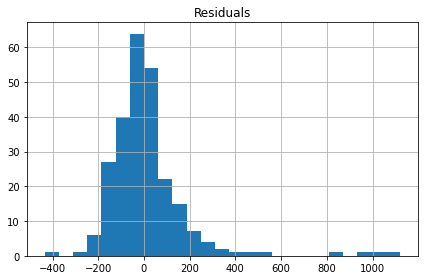

In [47]:
# Plot Residuals
pred_y = best_model.predict(valid_X[best_variables])
all_residuals = valid_y - pred_y

ax = pd.DataFrame({'Residuals': all_residuals}).hist(bins=25)

plt.tight_layout()
plt.show()

#### Question 3.2.2
Regression trees (6 Points)


In [40]:
# user grid search to find optimized tree
param_grid = {
    'max_depth': [1, 2, 3, 4, 5, 10, 15, 20, 25], 
    'min_impurity_decrease': [0, 0.00001, 0.0001, 0.001, 0.005, 0.01], 
    'min_samples_split': [5, 10, 20, 30, 40, 50], 
}
gridSearch = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(train_X, train_y)
print('Initial parameters: ', gridSearch.best_params_)

Initial parameters:  {'max_depth': 5, 'min_impurity_decrease': 0, 'min_samples_split': 10}


In [45]:
# use first grid search to find more optimal hyperparamters.
param_grid = {
    'max_depth': [5, 6, 7, 8, 9, 10], 
    'min_impurity_decrease': [0, 0.000001, 0.000002, 0.000003, 0.000005, 0.000006, 0.000007, 0.000008], 
    'min_samples_split': [6,7,8,9,10,11,12,13,14,15,16,18,20], 
}
gridSearch = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=5, n_jobs=-1)
gridSearch.fit(train_X, train_y)
print('Improved parameters: ', gridSearch.best_params_)

regTree = gridSearch.best_estimator_

print('\nTraining Results:')
pred_y = regTree.predict(train_X)
regressionSummary(train_y, pred_y)

print('\nValidation Results:')
pred_y = regTree.predict(valid_X)
regressionSummary(valid_y, pred_y)


Improved parameters:  {'max_depth': 5, 'min_impurity_decrease': 0, 'min_samples_split': 11}

Training Results:

Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 133.0171
            Mean Absolute Error (MAE) : 83.9819
          Mean Percentage Error (MPE) : -98.3802
Mean Absolute Percentage Error (MAPE) : 123.0651

Validation Results:

Regression statistics

                      Mean Error (ME) : 18.0482
       Root Mean Squared Error (RMSE) : 188.2868
            Mean Absolute Error (MAE) : 106.8608
          Mean Percentage Error (MPE) : -74.2434
Mean Absolute Percentage Error (MAPE) : 103.2969


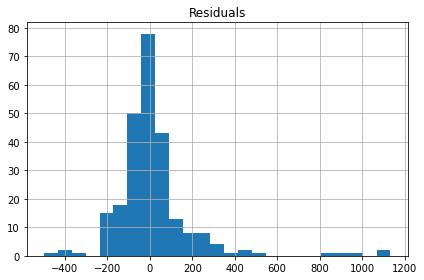

In [46]:
# Plot Residuals
pred_y = regTree.predict(valid_X)
all_residuals = valid_y - pred_y

ax = pd.DataFrame({'Residuals': all_residuals}).hist(bins=25)

plt.tight_layout()
plt.show()

#### Question 3.2.3
Choose one model on the basis of its performance on the validation data and explain your reasoning for selecting it (6 Points)

**Answer:** 

---

I choose to go with the regression model over the decision tree model. I choose the regression model because all of the following measures, Mean Error (ME), Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), Mean Percentage Error (MPE), and Mean Absolute Percentage Error (MAPE) were all better than those from the decision tree model. You can see the difference between the two in their residual plots. The regression tree residual plot has smaller overall residuals and a slightly tighter variance.



---

## Question 4
Return to the original test data partition. Note that this test data partition includes both purchasers and nonpurchasers. Create a new data frame called Score Analysis that contains the test data portion of this dataset.


In [19]:
Score_Analysis = testData
Score_Analysis

,sequence_number,US,source_a,source_c,source_b,source_d,source_e,source_m,source_o,source_h,...,source_x,source_w,Freq,last_update_days_ago,1st_update_days_ago,Web order,Gender=male,Address_is_res,Purchase,Spending
674,675,1,0,0,0,0,0,0,0,1,...,0,0,2,1346,1386,0,1,1,0,0
1699,1700,1,0,0,0,0,0,0,0,0,...,0,1,2,434,463,1,0,0,1,184
1282,1283,1,1,0,0,0,0,0,0,0,...,0,0,1,3717,3717,0,1,0,0,0
1315,1316,1,1,0,0,0,0,0,0,0,...,0,0,9,1128,3376,1,1,0,1,1289
1210,1211,0,0,0,0,0,1,0,0,0,...,0,0,0,2765,2765,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537,538,1,0,0,0,0,0,0,0,0,...,1,0,1,1184,3376,0,1,0,1,44
1450,1451,1,1,0,0,0,0,0,0,0,...,0,0,2,1135,2121,1,1,0,1,281
1919,1920,0,0,0,0,0,1,0,0,0,...,0,0,3,2296,2564,1,0,0,1,514
255,256,1,0,0,0,0,0,0,0,1,...,0,0,2,1415,1436,0,1,1,0,0


### Question 4.1
Add a column to the data frame with the predicted scores from the logistic regression. (4 Points)


In [20]:
left = Score_Analysis
right = logit_result.iloc[Score_Analysis.index]
Score_Analysis_pred = left.join(right)
Score_Analysis_pred

,sequence_number,US,source_a,source_c,source_b,source_d,source_e,source_m,source_o,source_h,...,1st_update_days_ago,Web order,Gender=male,Address_is_res,Purchase,Spending,actual,p(0),p(1),predicted
674,675,1,0,0,0,0,0,0,0,1,...,1386,0,1,1,0,0,0,9.901345e-01,0.009866,0
1699,1700,1,0,0,0,0,0,0,0,0,...,463,1,0,0,1,184,1,4.914037e-02,0.950860,1
1282,1283,1,1,0,0,0,0,0,0,0,...,3717,0,1,0,0,0,0,4.686445e-01,0.531356,1
1315,1316,1,1,0,0,0,0,0,0,0,...,3376,1,1,0,1,1289,1,1.949330e-07,1.000000,1
1210,1211,0,0,0,0,0,1,0,0,0,...,2765,1,0,0,0,0,0,8.713372e-01,0.128663,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537,538,1,0,0,0,0,0,0,0,0,...,3376,0,1,0,1,44,1,6.632571e-01,0.336743,0
1450,1451,1,1,0,0,0,0,0,0,0,...,2121,1,1,0,1,281,1,5.344345e-02,0.946557,1
1919,1920,0,0,0,0,0,1,0,0,0,...,2564,1,0,0,1,514,1,2.730050e-02,0.972699,1
255,256,1,0,0,0,0,0,0,0,1,...,1436,0,1,1,0,0,0,9.901900e-01,0.009810,0


### Question 4.2
Add another column with the predicted spending amount from the prediction model
chosen. (4 Points)

In [74]:
# Prep data for prediction
Norm_X = ts_df_Norm.drop(['Purchase', 'Spending','sequence_number'], axis=1)
Norm_y = ts_df_Norm['Spending']

# Predict Spend
reg_pred = best_model.predict(Norm_X[best_variables])

# Save Results
reg_full_result = pd.DataFrame({'Predicted_Spend': reg_pred})

reg_full_result.shape

(2000, 1)

In [96]:
# Join the data
left = Score_Analysis_pred
right = reg_full_result.iloc[Score_Analysis_pred.index]
Score_Analysis_pred_rev = left.join(right)


### Question 4.3
Add a column for “adjusted probability of purchase” by multiplying “predicted probability of purchase” by 0.107. This is to adjust for oversampling the purchasers (see earlier description). (4 Points)

In [97]:
Score_Analysis_pred_rev['adjusted probability of purchase'] = Score_Analysis_pred_rev['p(1)']*probability_of_purchase

### Question 4.4
Add a column for expected spending: adjusted probability of purchase × predicted
spending. (4 Points)


In [98]:
Score_Analysis_pred_rev['expected spending'] = Score_Analysis_pred_rev['adjusted probability of purchase']*Score_Analysis_pred_rev['Predicted_Spend']

### Question 4.5
Plot the cumulative gains chart of the expected spending (cumulative expected
spending as a function of number of records targeted). (6 Points)


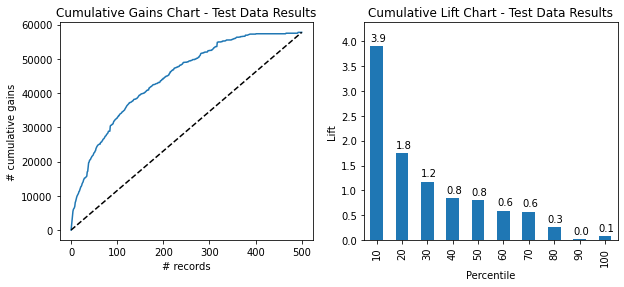

In [99]:
Score_Analysis_pred_rev = Score_Analysis_pred_rev.sort_values(by=['expected spending'], ascending=False)
# Gains and Lift Chart
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
gainsChart(Score_Analysis_pred_rev.Spending, ax=axes[0])
liftChart(Score_Analysis_pred_rev.Spending, title=False, ax=axes[1])
axes[0].set_title('Cumulative Gains Chart - Test Data Results')
axes[1].set_title('Cumulative Lift Chart - Test Data Results')

plt.show()

### Question 4.6
Using this cumulative gains curve, estimate the gross profit that would result from mailing to the 180,000 names on the basis of your data mining models. (6 Points)


In [100]:
mail_list = 180000
factor = mail_list/ len(Score_Analysis_pred_rev)
exp_rev_test = Score_Analysis_pred_rev['expected spending'].sum()
gross_profit = exp_rev_test*factor

print(f'Estimated Gross Profit = ${gross_profit:,.2f}')

Estimated Gross Profit = $1,946,577.10


## Question 5
Briefly explain, in two to three paragraphs, the business objective, the data mining models used, why they were used, the model results, and your recommendations to your non-technical stakeholder team. (10 Points)